5000 5% (0m 4s) 1.9732 Manfredi / Italian ✓
10000 10% (0m 8s) 1.8198 Monette / French ✓
15000 15% (0m 12s) 0.5848 Vyazov / Russian ✓
20000 20% (0m 16s) 5.0183 Roosa / Spanish ✗ (Dutch)
25000 25% (0m 19s) 1.1419 Koury / Arabic ✓
30000 30% (0m 22s) 1.0926 Sepulveda / Spanish ✓
35000 35% (0m 25s) 2.9539 Jamussa / Japanese ✗ (Greek)
40000 40% (0m 28s) 0.8256 Ma / Vietnamese ✓
45000 45% (0m 31s) 0.1159 Egonidis / Greek ✓
50000 50% (0m 34s) 0.3497 Sebastino / Italian ✓
55000 55% (0m 37s) 0.4986 Rahal / Arabic ✓
60000 60% (0m 41s) 1.6362 Schultheis / Dutch ✗ (German)
65000 65% (0m 44s) 1.8250 Cann / Korean ✗ (Dutch)
70000 70% (0m 47s) 0.0895 Lavoie / French ✓
75000 75% (0m 50s) 1.0854 Buffone / French ✗ (Italian)
80000 80% (0m 53s) 0.6724 Maneates / Greek ✓
85000 85% (0m 56s) 0.5293 Sugimura / Japanese ✓
90000 90% (0m 59s) 1.3682 Alessi / Arabic ✗ (Italian)
95000 95% (1m 2s) 0.0612 Patselas / Greek ✓
100000 100% (1m 5s) 0.2062 Skomicka / Czech ✓


/tmp/ipykernel_91342/794498808.py:173: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_91342/794498808.py:174: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


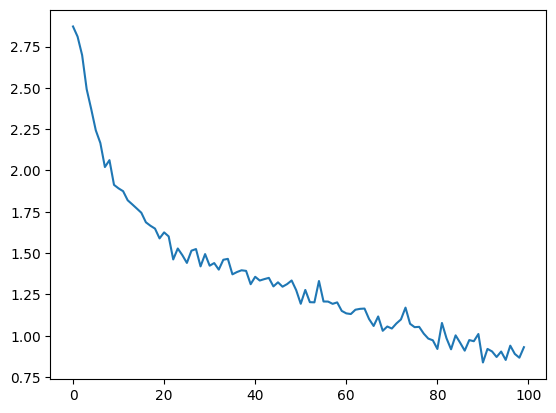

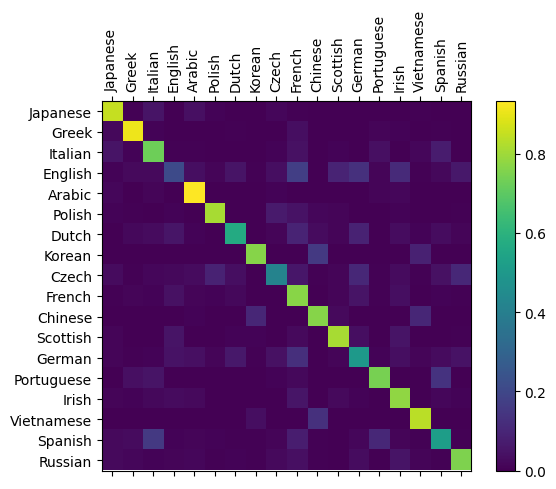


> Dovesky
(-0.15) Russian
(-2.74) Czech
(-3.66) Irish

> Jackson
(-0.08) Scottish
(-3.11) English
(-3.93) Russian

> Satoshi
(-0.15) Japanese
(-2.52) Italian
(-4.43) Arabic


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from io import open
import glob
import os
import unicodedata
import string

def findFiles(path): return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

category_lines = {}
all_categories = []
for filename in findFiles('data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' %
              (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

plt.figure()
plt.plot(all_losses)

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


5000 5% (0m 8s) 2.8783 Hiorvst / Scottish ✗ (Czech)
10000 10% (0m 15s) 2.7206 Lawrenz / German ✓
15000 15% (0m 22s) 3.0849 Lagana / Japanese ✗ (Italian)
20000 20% (0m 29s) 2.2338 Pellegrino / Russian ✗ (Italian)
25000 25% (0m 36s) 1.2606 Yeo / Korean ✓
30000 30% (0m 44s) 3.7302 Ven / Vietnamese ✗ (Dutch)
35000 35% (0m 51s) 4.1963 Komo / Korean ✗ (Czech)
40000 40% (0m 57s) 1.5866 Garcia / Japanese ✗ (Portuguese)
45000 45% (1m 5s) 2.7715 Parma / Portuguese ✗ (Italian)
50000 50% (1m 13s) 0.8326 Fabre / French ✓
55000 55% (1m 20s) 2.4374 Isbill / Irish ✗ (English)
60000 60% (1m 27s) 0.2886 Schrijnemakers / Dutch ✓
65000 65% (1m 34s) 1.9798 Bonnet / English ✗ (French)
70000 70% (1m 40s) 2.0005 Jewkes / Dutch ✗ (English)
75000 75% (1m 49s) 0.7821 Roijacker / Dutch ✓
80000 80% (1m 55s) 1.5091 Hutchins / Dutch ✗ (English)
85000 85% (2m 2s) 0.5854 Mateus / Portuguese ✓
90000 90% (2m 9s) 5.2387 Pecheritsa / Spanish ✗ (Russian)
95000 95% (2m 16s) 0.0113 Chuhontsev / Russian ✓
100000 100% (2m 25s)

/tmp/ipykernel_91342/1824067818.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_91342/1824067818.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


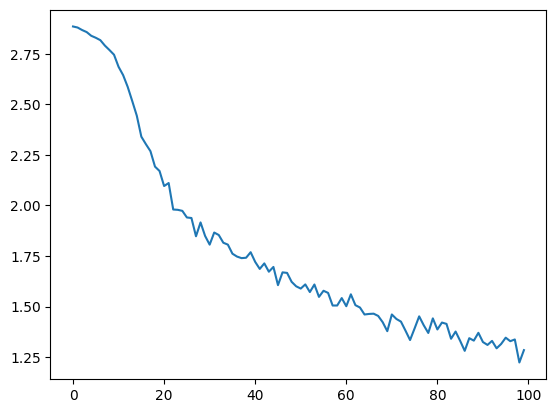

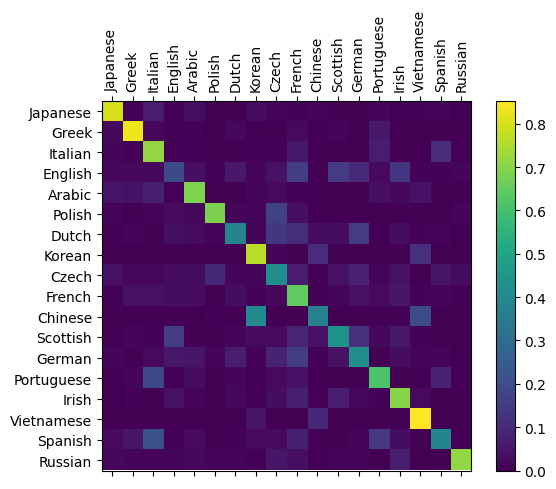


> Dovesky
(-0.71) Russian
(-1.13) Czech
(-2.58) English

> Jackson
(-0.33) Scottish
(-1.85) English
(-3.58) Czech

> Satoshi
(-0.72) Arabic
(-0.82) Japanese
(-3.42) Italian


In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRUCell(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = self.gru(input, hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
gru = GRU(n_letters, n_hidden, n_categories)

def train(category_tensor, line_tensor):
    hidden = gru.initHidden()
    gru.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    for p in gru.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

current_loss = 0
all_losses = []
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' %
              (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

plt.figure()
plt.plot(all_losses)

def evaluate(line_tensor):
    hidden = gru.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)
    return output

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


5000 5% (0m 8s) 2.8786 Kotsilimbas / Dutch ✗ (Greek)
10000 10% (0m 16s) 2.8899 Rooijakker / Italian ✗ (Dutch)
15000 15% (0m 24s) 2.7977 Fuentes / Greek ✗ (Spanish)
20000 20% (0m 32s) 2.8806 Eoin / Korean ✗ (Irish)
25000 25% (0m 39s) 2.6854 Kennedy / English ✗ (Scottish)
30000 30% (0m 47s) 2.7646 Makhrov / Italian ✗ (Russian)
35000 35% (0m 56s) 2.3877 Milne / English ✗ (Scottish)
40000 40% (1m 4s) 2.1571 Zelinka / Polish ✗ (Czech)
45000 45% (1m 12s) 2.0493 Legrand / German ✗ (French)
50000 50% (1m 20s) 2.7938 Maly / Irish ✗ (Czech)
55000 55% (1m 29s) 0.9804 Pavoni / Italian ✓
60000 60% (1m 36s) 1.4257 O'Donnell / Irish ✓
65000 65% (1m 45s) 1.0272 Coilean / Irish ✓
70000 70% (1m 53s) 1.1032 Sauveterre / French ✓
75000 75% (2m 3s) 1.4888 Apeldoorn / Scottish ✗ (Dutch)
80000 80% (2m 11s) 0.2580 Shiraishi / Japanese ✓
85000 85% (2m 19s) 0.0151 Akrivopoulos / Greek ✓
90000 90% (2m 27s) 1.7076 Ritchie / French ✗ (Scottish)
95000 95% (2m 36s) 0.1136 Mingalev / Russian ✓
100000 100% (2m 44s) 1.

/tmp/ipykernel_91342/164282884.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_91342/164282884.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


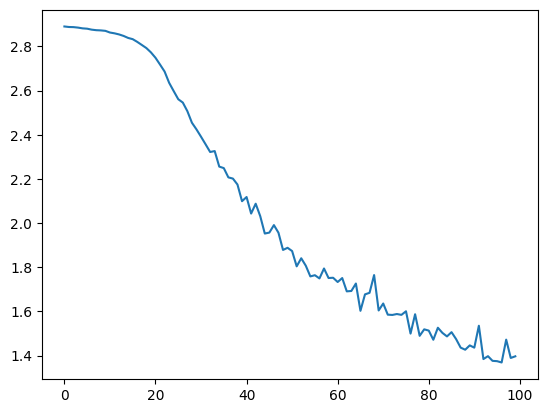

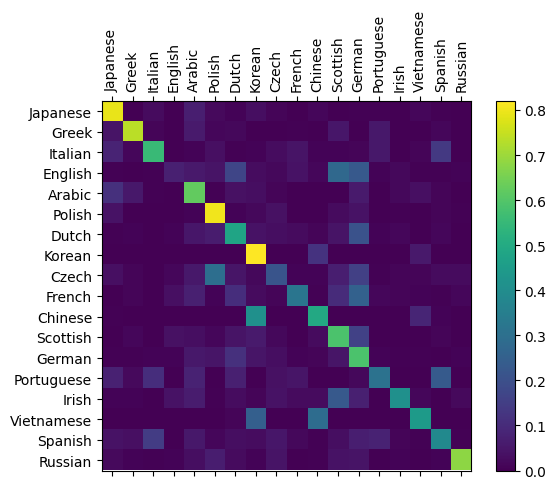


> Dovesky
(-0.97) Russian
(-1.44) Polish
(-1.53) Czech

> Jackson
(-0.47) Scottish
(-2.09) English
(-2.36) Polish

> Satoshi
(-0.55) Japanese
(-1.04) Arabic
(-3.50) Polish


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTMCell(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden, cell = hidden
        hidden, cell = self.lstm(input, (hidden, cell))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, (hidden, cell)

    def initHidden(self):
        return (torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size))

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

def train(category_tensor, line_tensor):
    hidden = lstm.initHidden()
    lstm.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    for p in lstm.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

current_loss = 0
all_losses = []
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' %
              (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

plt.figure()
plt.plot(all_losses)

def evaluate(line_tensor):
    hidden = lstm.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)
    return output

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

def evaluate_model_performance(model):
    y_true = []
    y_pred = []

    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output = evaluate(line_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)

        y_true.append(category_i)
        y_pred.append(guess_i)

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=all_categories))

    return y_true, y_pred

print("\nEvaluating RNN Performance:")
y_true_rnn, y_pred_rnn = evaluate_model_performance(rnn)



Evaluating RNN Performance:
Accuracy: 51.33%

Classification Report:
              precision    recall  f1-score   support

    Japanese       0.63      0.79      0.70       565
       Greek       0.83      0.75      0.79       569
     Italian       0.67      0.56      0.61       579
     English       0.42      0.08      0.13       587
      Arabic       0.47      0.60      0.53       584
      Polish       0.54      0.78      0.64       506
       Dutch       0.40      0.44      0.42       538
      Korean       0.44      0.80      0.57       561
       Czech       0.37      0.22      0.28       521
      French       0.53      0.28      0.37       543
     Chinese       0.47      0.51      0.48       565
    Scottish       0.37      0.54      0.44       552
      German       0.29      0.64      0.40       505
  Portuguese       0.60      0.34      0.43       567
       Irish       0.79      0.43      0.56       538
  Vietnamese       0.63      0.41      0.50       579
     Spanis

In [ ]:

print("\nEvaluating GRU Performance:")
y_true_gru, y_pred_gru = evaluate_model_performance(gru)



Evaluating GRU Performance:
Accuracy: 51.11%

Classification Report:
              precision    recall  f1-score   support

    Japanese       0.63      0.79      0.70       562
       Greek       0.79      0.75      0.77       576
     Italian       0.65      0.56      0.60       552
     English       0.37      0.08      0.13       571
      Arabic       0.46      0.63      0.53       558
      Polish       0.56      0.80      0.65       542
       Dutch       0.42      0.48      0.45       565
      Korean       0.43      0.83      0.57       534
       Czech       0.34      0.21      0.26       510
      French       0.51      0.28      0.36       543
     Chinese       0.47      0.51      0.49       546
    Scottish       0.37      0.54      0.44       551
      German       0.32      0.58      0.41       602
  Portuguese       0.58      0.29      0.38       591
       Irish       0.75      0.42      0.54       525
  Vietnamese       0.65      0.43      0.52       523
     Spanis

In [ ]:
print("\nEvaluating LSTM Performance:")
y_true_lstm, y_pred_lstm = evaluate_model_performance(lstm)


Evaluating LSTM Performance:
Accuracy: 51.88%

Classification Report:
              precision    recall  f1-score   support

    Japanese       0.60      0.77      0.68       551
       Greek       0.77      0.73      0.75       524
     Italian       0.67      0.56      0.61       531
     English       0.45      0.08      0.14       545
      Arabic       0.47      0.65      0.55       537
      Polish       0.54      0.78      0.64       524
       Dutch       0.40      0.49      0.44       556
      Korean       0.44      0.80      0.57       599
       Czech       0.41      0.21      0.28       580
      French       0.54      0.28      0.36       562
     Chinese       0.47      0.52      0.50       576
    Scottish       0.42      0.59      0.49       587
      German       0.29      0.61      0.40       527
  Portuguese       0.61      0.32      0.42       580
       Irish       0.79      0.45      0.57       527
  Vietnamese       0.67      0.41      0.51       573
     Spani